#链接谷歌云盘和Colab

In [1]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 131289 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.6-0ubuntu1~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.6-0ubuntu1~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.6-0ubuntu1~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=ht

#查看当前路径

In [2]:
!mkdir -p drive
!google-drive-ocamlfuse -o nonempty drive
import os
os.chdir("drive")
!ls

aclImdb_v1.tar.gz     residual_plot.png      Titanic
data_description.txt  Sales		     torchtest.ipynb
drive		      sample_submission.csv  train.csv
GuodongDrive	      Sense1.ipynb	     Untitled0.ipynb
House		      Sense2.ipynb（副本）   XGboost_practice1.ipynb
Houseprice.ipynb      Sense.ipynb	     XGboost_practice2.ipynb
huawei		      sensePY.ipynb	     剑指offer
labeledTrainData.tsv  submission.csv	     数组和链表.desktop
neg		      test.csv		     糖尿病数据.txt
practice	      testData.tsv


#选择路径

In [3]:
os.chdir("practice")
!ls

missing_data.xls  model.xls  漏电用户自动识别.ipynb


#开始

导入库

In [0]:
import matplotlib.pyplot as plt
#from random import shuffle
from sklearn.utils import shuffle
import pandas as pd
from keras.layers.core import Activation, Dense
from keras.models import Sequential
from scipy.interpolate import lagrange
from sklearn.externals import joblib
from sklearn.metrics import confusion_matrix, roc_curve
from sklearn.tree import DecisionTreeClassifier

#数据分析及处理



In [11]:
data = pd.read_excel('missing_data.xls',header = None)
data.head()  #三个用户一个月用电量

,0,1,2
0,235.8333,324.0343,478.3231
1,236.2708,325.6379,515.4564
2,238.0521,328.0897,517.0909
3,235.9063,NaN,514.8900
4,236.7604,268.8324,NaN


In [0]:
def lagrange_interp(s,n,k=5):     # s为列向量，n为被插值的位置，k为取前后的数据个数，默认为5
  y = s[list(range(n-k,n))+list(range(n+1,n+1+k))]
  y = y[y.notnull()] #剔除空值
  return lagrange(y.index,list(y))(n)

In [13]:
for i in data.columns:
  for j in range(len(data)):
    if (data[i].isnull())[j]:
      data[i][j] = lagrange_interp(data[i],j)
data.head()

/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:942: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


,0,1,2
0,235.8333,324.034300,478.323100
1,236.2708,325.637900,515.456400
2,238.0521,328.089700,517.090900
3,235.9063,203.462116,514.890000
4,236.7604,268.832400,493.352591


In [0]:
data.to_excel('processed_data.xls',header = None,index = False)

#自定义混淆矩阵可视化

In [0]:
def cm_plot(y,yp):
  cm = confusion_matrix(y,yp)
  plt.matshow(cm, cmap = plt.cm.Greens)
  plt.colorbar()
  
  for x in range(len(cm)):
    for y in range(len(cm)):
        plt.annotate(
            cm[x, y],
            xy=(x, y),
            horizontalalignment='center',
            verticalalignment='center')

  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  return plt

#CART决策树预测

In [38]:
data = pd.read_excel('model.xls')
data = shuffle(data)
data.head()

,电量趋势下降指标,线损指标,告警类指标,是否窃漏电
45,2,1,0,1
267,5,1,0,0
282,4,0,0,0
13,4,0,2,0
55,6,0,0,0


In [0]:
data = data.values

In [40]:
# 设置训练数据比8:2
p = 0.8
train = data[:int(len(data) * p), :]
test = data[int(len(data) * p):, :]

# 构建CART决策树模型
treefile = 'tree.pkl'
tree = DecisionTreeClassifier()
tree.fit(train[:, :3], train[:, 3])

joblib.dump(tree, treefile)

['tree.pkl']

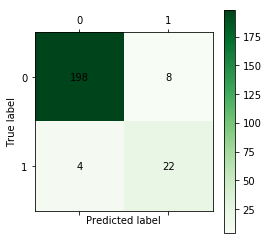

In [44]:
 cm_plot(train[:, 3], tree.predict(train[:, :3])).show()  # 显示混淆矩阵可视化结果

#绘制ROC曲线

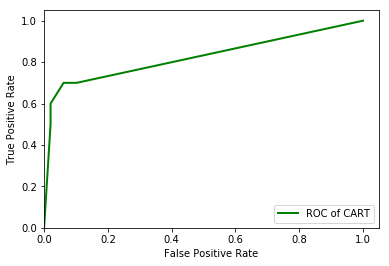

[2.         1.         0.66666667 0.33333333 0.14285714 0.        ]


In [45]:
fpr, tpr, thresholds = roc_curve(
    test[:, 3], tree.predict_proba(test[:, :3])[:, 1], pos_label=1)
plt.plot(fpr, tpr, linewidth=2, label='ROC of CART', color='green')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# 设定边界范围
plt.ylim(0, 1.05)
plt.xlim(0, 1.05)
plt.legend(loc=4)
plt.show()
print(thresholds)

#  使用LM神经网络模型

In [47]:
data = pd.read_excel('model.xls')
data = shuffle(data)
data.head()

,电量趋势下降指标,线损指标,告警类指标,是否窃漏电
208,4,1,0,0
9,4,1,0,0
58,9,1,4,1
141,5,0,1,0
194,3,1,1,0


In [0]:
data = data.values

In [0]:
# 设置训练数据比8:2
p = 0.8
train = data[:int(len(data) * p), :]
test = data[int(len(data) * p):, :]

Epoch 1/100
232/232 [==============================] - 0s 2ms/step - loss: 0.6532
Epoch 2/100
232/232 [==============================] - 0s 922us/step - loss: 0.5578
Epoch 3/100
232/232 [==============================] - 0s 951us/step - loss: 0.5246
Epoch 4/100
232/232 [==============================] - 0s 937us/step - loss: 0.4967
Epoch 5/100
232/232 [==============================] - 0s 955us/step - loss: 0.4724
Epoch 6/100
232/232 [==============================] - 0s 939us/step - loss: 0.4497
Epoch 7/100
232/232 [==============================] - 0s 934us/step - loss: 0.4284
Epoch 8/100
232/232 [==============================] - 0s 969us/step - loss: 0.4102
Epoch 9/100
232/232 [==============================] - 0s 964us/step - loss: 0.3923
Epoch 10/100
232/232 [==============================] - 0s 977us/step - loss: 0.3724
Epoch 11/100
232/232 [==============================] - 0s 1ms/step - loss: 0.3573
Epoch 12/100
232/232 [==============================] - 0s 1ms/step - loss: 0.

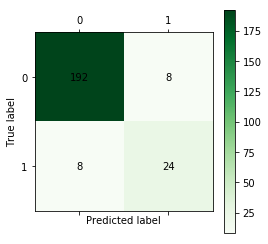

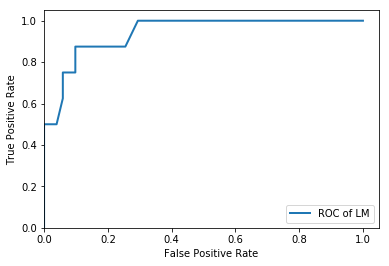

[1.9997224e+00 9.9972236e-01 8.3207119e-01 5.9764999e-01 5.3802413e-01
 4.2008427e-01 3.0810112e-01 2.2443968e-01 3.3409089e-02 3.0421972e-02
 2.7816683e-02 2.5348336e-02 2.0930976e-02 7.7363253e-03 4.9172342e-03
 3.3946931e-03 3.3697784e-03 3.0868948e-03 2.3318231e-03 1.9454956e-03
 1.2255907e-03 8.9538097e-04 5.1119924e-04]


In [53]:
net = Sequential() #建立神经网络
# 添加输入层（3节点）到隐藏层（10节点）的连接
net.add(Dense(10, input_shape=(3, )))
net.add(Activation('relu'))  # 隐藏层使用relu激活函数
#添加隐藏层（10节点）到输出层（1节点）的连接
net.add(Dense(1, input_shape=(10, )))
net.add(Activation('sigmoid'))  # 输出层使用sigmoid激活函数
net.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    sample_weight_mode="binary")  # 编译模型，使用adam方法求解

net.fit(train[:, :3], train[:, 3], epochs=100, batch_size=1)
net.save_weights('net.model')

predict_result = net.predict_classes(train[:, :3]).reshape(
    len(train))  # 预测结果变形
#'''这里要提醒的是，keras用predict给出预测概率，predict_classes才是给出预测类别，而且两者的预测结果都是n x 1维数组，而不是通常的 1 x n'''

cm_plot(train[:, 3], predict_result).show()

predict_result = net.predict(test[:, :3]).reshape(len(test))
fpr, tpr, thresholds = roc_curve(test[:, 3], predict_result, pos_label=1)
plt.plot(fpr, tpr, linewidth=2, label='ROC of LM')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.ylim(0, 1.05)
plt.xlim(0, 1.05)
plt.legend(loc=4)
plt.show()
print(thresholds)
